In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 23.0 MB/s eta 0:00:00


In [3]:
# import dataset
from datasets import load_dataset

data = load_dataset(
    "jamescalam/image-text-demo",
    split="train",
    revision="180fdae",
)
data

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image-text-demo downloaded and prepared to /root/.cache/huggingface/datasets/jamescalam___image-text-demo/default/0.0.0/83e33802f1af183872ab59b5bf8b7ae25968f4e294f8529fdae035f54b9a5abc. Subsequent calls will reuse this data.


Dataset({
    features: ['text', 'image'],
    num_rows: 21
})

In [5]:
type(data[2]['image'])


PIL.JpegImagePlugin.JpegImageFile

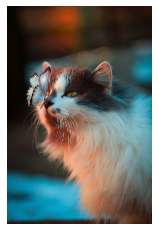

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Load the image from a URL or file path
img = data[2]['image']

# Plot the image using Matplotlib
plt.imshow(img)
plt.axis('off')
plt.show()

# Download the image
img.save('image.jpg')
from google.colab import files
files.download('image.jpg')

In [1]:
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
# transform the image into tensor
transt = transforms.ToTensor()
data = Image.open("image.jpg")

img = transt(data)
img.data.shape

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
# add batch dimension and shift color channels
patches = img.data.unfold(0,3,3)
patches.shape

torch.Size([1, 5184, 3456, 3])

In [10]:
# break the image into patches (in height dimension)
patch = 256

new_patches = patches.unfold(1, patch, patch)
new_patches.shape

torch.Size([1, 20, 3456, 3, 256])

In [11]:
# break the image into patches (in width dimension)
new_patches_1 = new_patches.unfold(2, patch, patch)
new_patches_1.shape

torch.Size([1, 20, 13, 3, 256, 256])

In [12]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [14]:
window = 6
stride = 1
# print(0, new_patches_1.shape[1]-window+1, stride)

# window slides from top to bottom
for Y in range(0, new_patches_1.shape[1]-window+1, stride):
    # window slides from left to right
    
    for X in range(0, new_patches_1.shape[2]-window+1, stride):
        # initialize an empty big_patch array
        
        big_patch = torch.zeros(patch*window, patch*window, 3)
        # this gets the current batch of patches that will make big_batch
        patch_batch = new_patches_1[0, Y:Y+window, X:X+window]
        # loop through each patch in current batch
        for y in range(patch_batch.shape[1]):
            for x in range(patch_batch.shape[0]):
                # add patch to big_patch
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # display current big_patch
#         print(patch_batch.shape)
        # plt.imshow(big_patch)
        # plt.show()

In [15]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.8 MB/s eta 0:00:00


In [16]:
from transformers import CLIPProcessor, CLIPModel
import torch

# define processor and model
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [17]:
window = 6
stride = 1

scores = torch.zeros(new_patches_1.shape[1], new_patches_1.shape[2])
runs = torch.ones(new_patches_1.shape[1], new_patches_1.shape[2])

for Y in range(0, new_patches_1.shape[1]-window+1, stride):
    for X in range(0, new_patches_1.shape[2]-window+1, stride):
        big_patch = torch.zeros(patch*window, patch*window, 3)
        patch_batch = new_patches_1[0, Y:Y+window, X:X+window]
        for y in range(window):
            for x in range(window):
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # we preprocess the image and class label with the CLIP processor
        inputs = processor(
            images=big_patch,  # big patch image sent to CLIP
            return_tensors="pt",  # tell CLIP to return pytorch tensor
            text="an animal",  # class label sent to CLIP
            padding=True
        ).to(device) # move to device if possible

        # calculate and retrieve similarity score
        score = model(**inputs).logits_per_image.item()
        # sum up similarity scores from current and previous big patches
        # that were calculated for patches within the current window
        scores[Y:Y+window, X:X+window] += score
        # calculate the number of runs on each patch within the current window
        runs[Y:Y+window, X:X+window] += 1


In [18]:
scores /= runs

In [19]:
import numpy as np

In [20]:
# clip the scores
scores = np.clip(scores-scores.mean(), 0, np.inf)

# normalize scores
scores = (
    scores - scores.min()) / (scores.max() - scores.min()
)


In [21]:
scores.shape, new_patches_1.shape


(torch.Size([20, 13]), torch.Size([1, 20, 13, 3, 256, 256]))

In [22]:
# transform the patches tensor
adj_patches = new_patches_1.squeeze(0).permute(3, 4, 2, 0, 1)
adj_patches.shape


torch.Size([256, 256, 3, 20, 13])

In [23]:
# multiply patches by scores
adj_patches = adj_patches * scores

# rotate patches to visualize
adj_patches = adj_patches.permute(3, 4, 2, 0, 1)
adj_patches.shape



torch.Size([20, 13, 3, 256, 256])

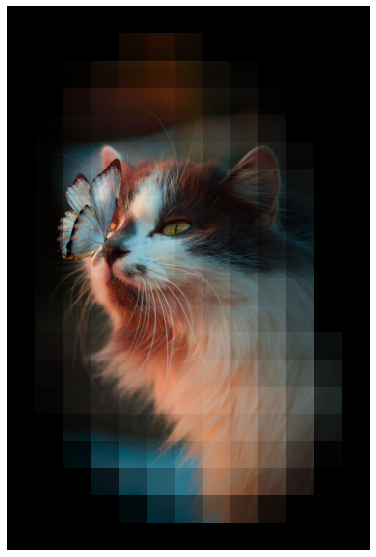

In [24]:
Y = adj_patches.shape[0]
X = adj_patches.shape[1]

fig, ax = plt.subplots(Y, X, figsize=(X*.5, Y*.5))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [25]:
# scores higher than 0.5 are positive
detection = scores > 0.5


In [26]:
# non-zero positions
np.nonzero(detection)

tensor([[ 2,  4],
        [ 2,  5],
        [ 3,  3],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
        [ 3,  7],
        [ 4,  2],
        [ 4,  3],
        [ 4,  4],
        [ 4,  5],
        [ 4,  6],
        [ 4,  7],
        [ 5,  2],
        [ 5,  3],
        [ 5,  4],
        [ 5,  5],
        [ 5,  6],
        [ 5,  7],
        [ 6,  2],
        [ 6,  3],
        [ 6,  4],
        [ 6,  5],
        [ 6,  6],
        [ 6,  7],
        [ 6,  8],
        [ 7,  1],
        [ 7,  2],
        [ 7,  3],
        [ 7,  4],
        [ 7,  5],
        [ 7,  6],
        [ 7,  7],
        [ 7,  8],
        [ 8,  1],
        [ 8,  2],
        [ 8,  3],
        [ 8,  4],
        [ 8,  5],
        [ 8,  6],
        [ 8,  7],
        [ 8,  8],
        [ 9,  1],
        [ 9,  2],
        [ 9,  3],
        [ 9,  4],
        [ 9,  5],
        [ 9,  6],
        [ 9,  7],
        [ 9,  8],
        [ 9,  9],
        [10,  2],
        [10,  3],
        [10,  4],
        [10,  5],
        [1

In [27]:
y_min, y_max = (
    np.nonzero(detection)[:,0].min().item(),
    np.nonzero(detection)[:,0].max().item()+1
)
y_min, y_max

(2, 19)

In [28]:
x_min, x_max = (
    np.nonzero(detection)[:,1].min().item(),
    np.nonzero(detection)[:,1].max().item()+1
)
x_min, x_max

(1, 11)

In [29]:
y_min *= patch
y_max *= patch
x_min *= patch
x_max *= patch
x_min, y_min

(256, 512)

In [30]:
height = y_max - y_min
width = x_max - x_min

height, width

(4352, 2560)

In [31]:
# image shape
img.data.numpy().shape

(3, 5184, 3456)

In [32]:
# move color channel to final dim
image = np.moveaxis(img.data.numpy(), 0, -1)
image.shape

(5184, 3456, 3)

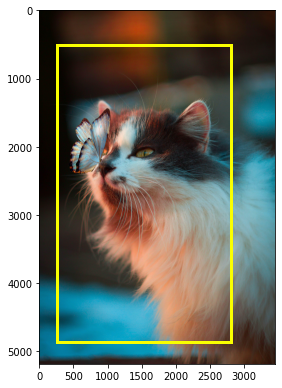

In [33]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))

ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle(
    (x_min, y_min), width, height,
    linewidth=3, edgecolor='#FAFF00', facecolor='none'
)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()